# CHAPTER 3 금융 데이터 분석을 위한 파이썬 활용법
## 3.1 바이앤홀드 전략
### 3.1.1 데이터 불러오기
* 삼성전자 주가 불러오기

In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [2]:
# 주가정보 불러오기, 2003-07-01
stock = fdr.DataReader('US500', start='2003-07-01')
# stock = fdr.DataReader('^KS11', start='2003-07-01')
# stock = fdr.DataReader('005930', start='2003-07-01')
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5034 entries, 2003-07-01 to 2023-06-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5034 non-null   float64
 1   High       5034 non-null   float64
 2   Low        5034 non-null   float64
 3   Close      5034 non-null   float64
 4   Adj Close  5034 non-null   float64
 5   Volume     5034 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 275.3 KB


### 3.1.2 결측치

In [3]:
# 결측치 확인
# stock[samsung.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
stock.isin([np.nan, np.inf, -np.inf]).sum(axis=0)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
# 결측치 제거
stock = stock.dropna()

### 3.1.3 데이터 슬라이싱

<Axes: xlabel='Date'>

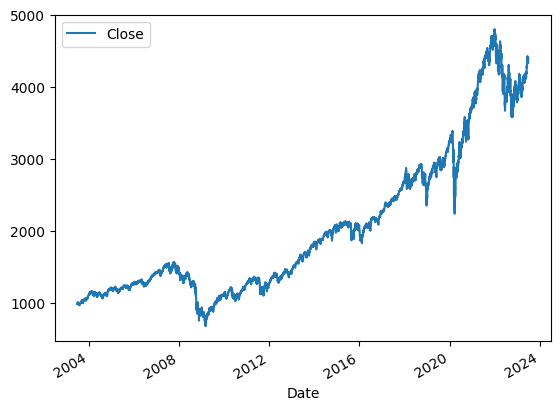

In [5]:
# 종가 준비
stock_price = stock.loc[:, ['Adj Close']].copy()
stock_price.columns = ['Close']
stock_price.plot()

<Axes: xlabel='Date'>

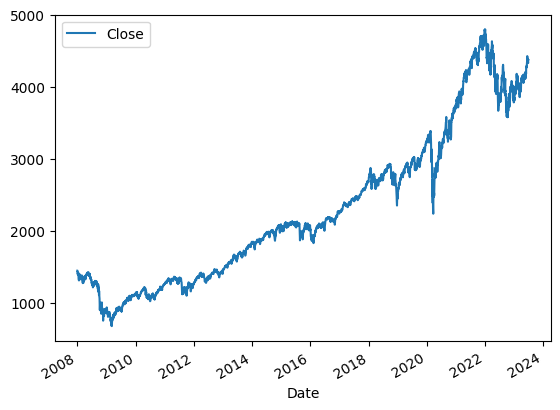

In [6]:
from_date = '2008-01-01'
to_date = '2023-06-28'
stock_price.loc[from_date:to_date].plot()

In [7]:
# Dates of U.S. recessions as inferred by GDP-based recession indicator
recessions = fdr.DataReader('FRED:JHDUSRGDPBR')
recessions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172 entries, 1980-01-01 to 2022-10-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   JHDUSRGDPBR  172 non-null    float64
dtypes: float64(1)
memory usage: 2.7 KB


In [8]:
# stock과 recession merge
# recession이 분기 데이터라 분기 종료까지 데이터를 만들어주기 위한 꼼수
merge_df = pd.concat([stock_price, recessions], axis=1, join='outer')
merge_df.fillna(method='ffill', inplace=True)
merge_df.columns = ['Close', 'Recession']
merge_df = merge_df.loc[from_date:to_date]
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3924 entries, 2008-01-01 to 2023-06-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      3924 non-null   float64
 1   Recession  3924 non-null   float64
dtypes: float64(2)
memory usage: 92.0 KB


In [9]:
# 리세션 구간 리스트 만들기
# list( (start, end) )
recession_range_list = []
prev_val = 0.0
start = merge_df.index[0]

for idx, val in merge_df.iterrows():
    if val['Recession'].item() != prev_val:
        if val['Recession'].item() == 1.0:
            start = idx
        else:
            recession_range_list.append((start, idx))

    prev_val = val['Recession'].item()

recession_range_list

[(Timestamp('2008-01-01 00:00:00'), Timestamp('2009-07-01 00:00:00')),
 (Timestamp('2020-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))]

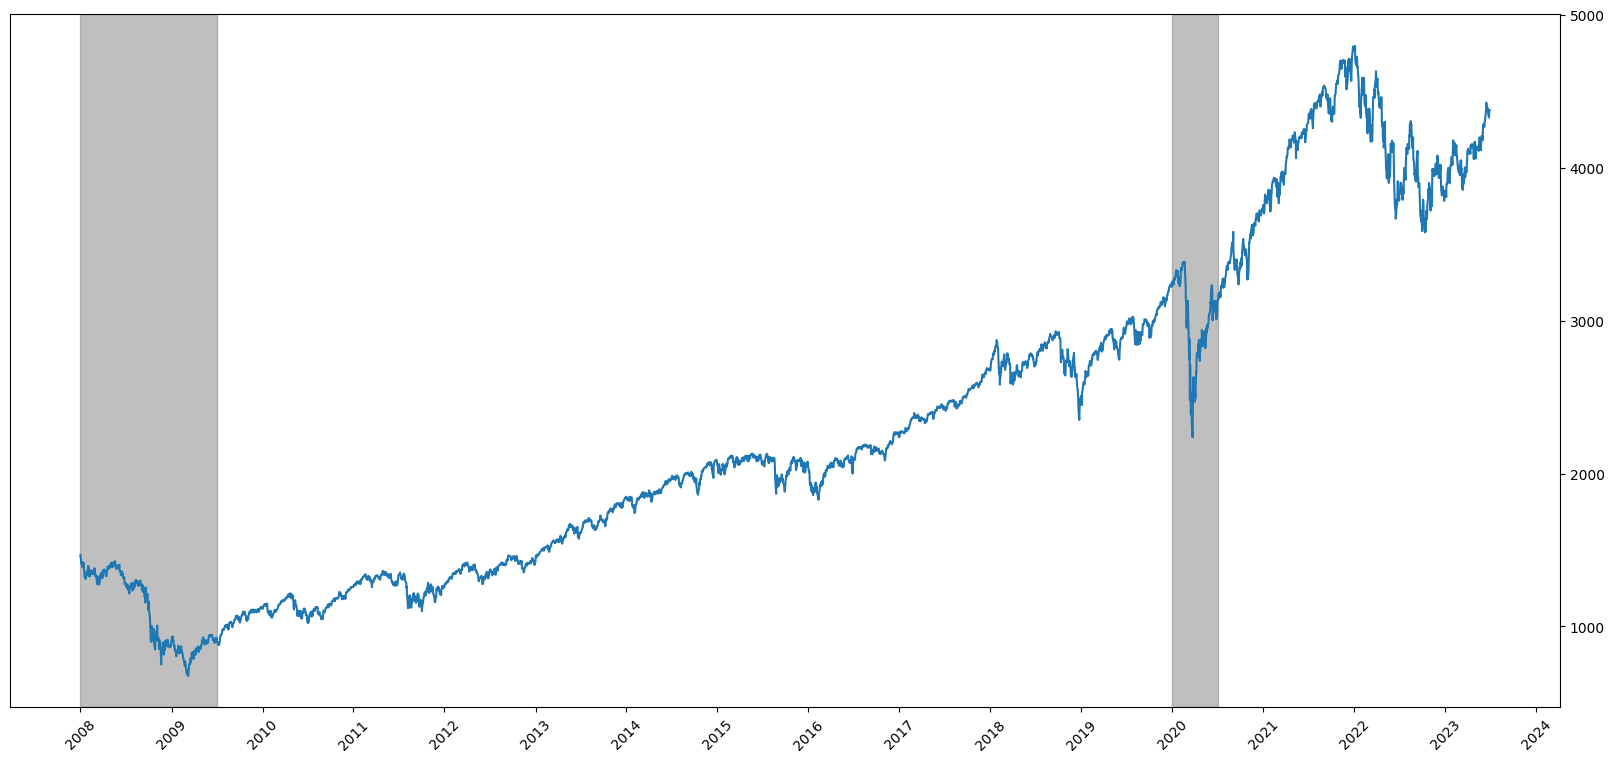

In [10]:
from matplotlib import dates

plt.figure(figsize=(20,9))
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.YearLocator())
ax.yaxis.tick_right()
plt.plot(merge_df['Close'])
for (start, end) in recession_range_list:
    plt.axvspan(start, end, color='gray', alpha=0.5)
plt.show()

In [11]:
from dateutil.relativedelta import relativedelta
fed_funds_rate = fdr.DataReader('FRED:FEDFUNDS')
merge_df = pd.merge(merge_df, fed_funds_rate[merge_df.index[0] - relativedelta(months=2):], how='outer', left_index=True, right_index=True)

In [12]:
merge_df = merge_df.fillna(method='ffill').dropna()
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3964 entries, 2008-01-01 to 2023-06-28
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      3964 non-null   float64
 1   Recession  3964 non-null   float64
 2   FEDFUNDS   3964 non-null   float64
dtypes: float64(3)
memory usage: 123.9 KB


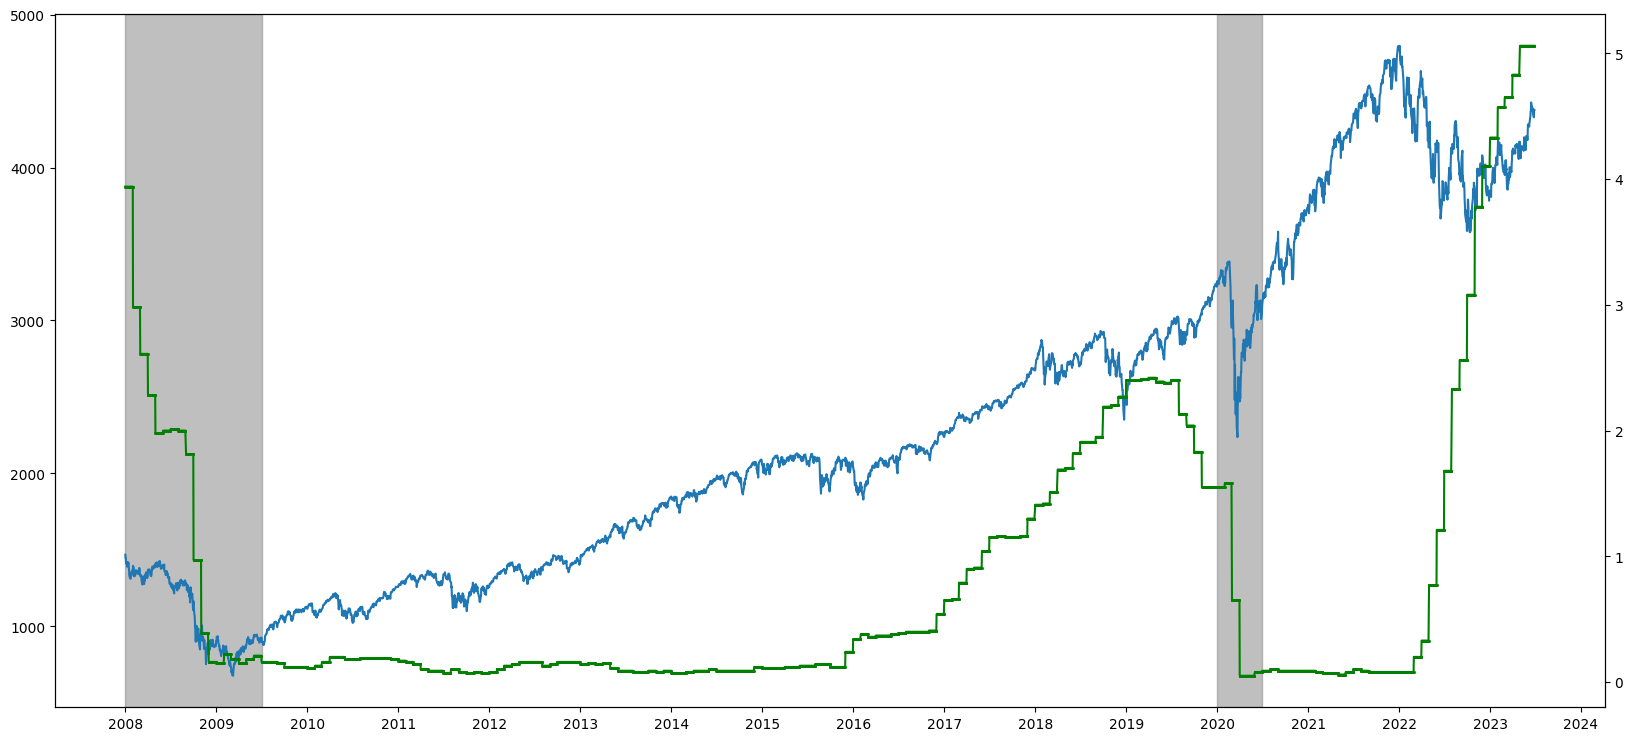

In [13]:
from matplotlib import dates

fig, ax1 = plt.subplots(figsize=(20,9))

ax1.xaxis.set_major_locator(dates.YearLocator())
ax1.yaxis.tick_right()
ax1.plot(merge_df['Close'])
for (start, end) in recession_range_list:
    plt.axvspan(start, end, color='gray', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(merge_df['FEDFUNDS'],'-s', color='green', markersize=1)

plt.show()

### 3.1.4 일별 수익률 계산

In [14]:
# pct_change() 함수
# stock_price['daily_rtn'] = stock_price['Close'].pct_change()
# stock_price['st_rtn'] = (1+stock_price['daily_rtn']).cumprod()
stock_price['daily_rtn'] = stock_price['Close']/stock_price['Close'].shift(1)
stock_price['st_rtn'] = (stock_price['daily_rtn']).cumprod()
stock_price.head()

,Close,daily_rtn,st_rtn
Date,,,
2003-07-01,982.320007,NaN,NaN
2003-07-02,993.750000,1.011636,1.011636
2003-07-03,985.700012,0.991899,1.003441
2003-07-07,1004.419983,1.018992,1.022498
2003-07-08,1007.840027,1.003405,1.025979


## 3.2 투자 성과 분석 지표
* 연평균 복리 수익률(compound annual growth rate, CAGR)
* 최대 낙폭(maximum draw down, MDD)
* 변동성(volatility, Vol)
* 샤프 지수(Sharpe ratio)
### 3.2.1 연평균 복리 수익률(CAGR)
* CAGR
```
CAGR
= ((마지막 가격/시작 가격) ^ (1/기간)) - 1
= ((마지막 가격/시작 가격) ^ (1/(일수/252))) - 1
= ((마지막 가격/시작 가격) ^ (252/일수)) - 1
```

In [15]:
CAGR = stock_price.iloc[-1]['st_rtn'] ** (252/len(stock_price.index)) - 1
CAGR

0.07790675832800242

### 3.2.2 최대 낙폭(MDD)
* MDD
```
최대낙폭
= min( (최저점 - 최고값) / 최고값 )
= min( 최저점 / 최고값 - 1 )
```

<Axes: xlabel='Date'>

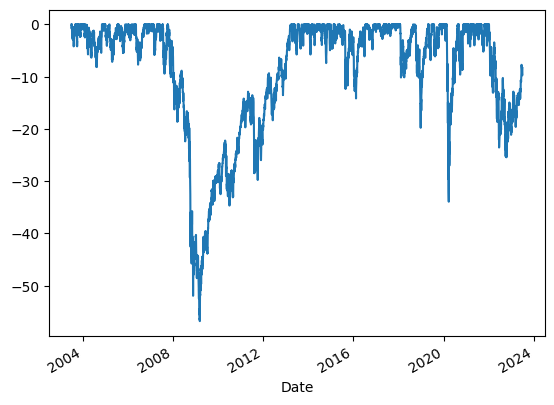

In [16]:
historical_max = stock_price.loc[:,'Close'].cummax()
daily_drawdown = (stock_price['Close'] / historical_max - 1) * 100
daily_drawdown.plot()

<Axes: xlabel='Date'>

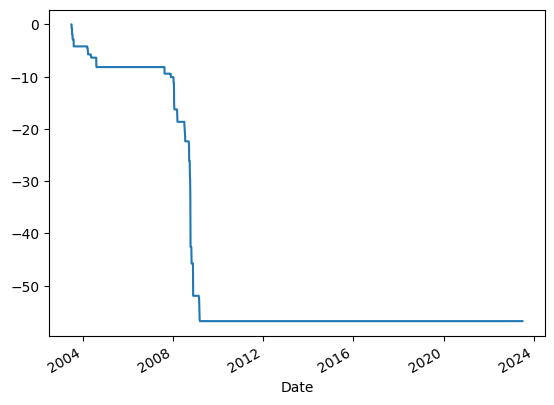

In [17]:
historical_dd = daily_drawdown.cummin()
historical_dd.plot()

### 3.2.3 변동성(Vol)
* 수익률의 표준편차를 변동성 지표로 이용

In [18]:
VOL = np.std(stock_price['daily_rtn']-1) * np.sqrt(252)
# VOL = np.std(stock_price['Close'].pct_change()) * np.sqrt(252)

### 3.2.4 샤프 지수

샤프지수
= (펀드수익률 - 무위험수익률 ) / 위험
= 연수익률 / 연간표준편차
= (일일수익률.mean()*252) / (일일표준편차 * $\sqrt{252}$)
= (일일수익률.mean() / 일일표준편차) * $\sqrt{252}$

In [19]:
Sharpe = (np.mean( stock_price['daily_rtn']-1) / np.std(stock_price['daily_rtn']-1)) * np.sqrt(252)
Sharpe

0.4881519691241452

### 3.2.5 성과 분석 결과

In [20]:
def get_evaluation(daily_return):
    """
    cagr, dd, mdd, vol, sharpe
    투자 성과 지표
    """
    # cumulativeReturn
    cumulativeReturn = daily_return.cumprod()
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    vol = np.std(daily_return-1) * np.sqrt(252)
    sharpe = np.mean(daily_return-1) * 252 / vol

    print(f"기간: {daily_return.index[0].strftime('%Y/%m/%d')} ~ {daily_return.index[-1].strftime('%Y/%m/%d')}")
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}\nvol: {vol}\nsharpe: {sharpe}")

    return cagr, dd, mdd, vol, sharpe

cagr, _, mdd, vol, sharp = get_evaluation(stock_price.loc['2008':,'daily_rtn'])
cagr, _, mdd, vol, sharp = get_evaluation(stock_price.loc['2013':,'daily_rtn'])
# cagr, _, mdd, vol, sharp = get_evaluation(stock_price['Close'].pct_change()+1)

기간: 2008/01/02 ~ 2023/06/29
최종 수익률: 2.994115874793475
cagr: 1.0734313602257832
mdd: 53.25119453927651
vol: 0.20730990382513326
sharpe: 0.44582184181717815
기간: 2013/01/02 ~ 2023/06/29
최종 수익률: 3.082646858326165
cagr: 1.113402841772266
mdd: 33.92496000609723
vol: 0.1745885462043435
sharpe: 0.7031013393941078


## 3.3 마치며
* cagr, mdd, vol, sharp 지표 계산